In [1]:
from qiskit.synthesis import QDrift
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli


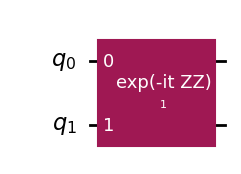

In [7]:
# Define the Hamiltonian
XX = Pauli('XX')
YY = Pauli('YY')
ZZ = Pauli('ZZ')
a = 1
b = -1
c = 1
# A simple Hamiltonian: a XX + b YY + c ZZ. Use the appropriate Pauli compose method to do this.
hamiltonian = a * YY.compose(b*XX)
reps = 10
time = 1

evo_gate = PauliEvolutionGate(hamiltonian, time, synthesis=QDrift(reps=reps))

qc = QuantumCircuit(2)
qc.append(evo_gate, [0, 1])

qc.draw('mpl')

In [12]:
# Sexier Hamiltonian: Hubbard model
from qiskit_nature.second_q.operators import FermionicOp

'''A FermionicOp represents a weighted sum of fermionic creation/annihilation operator terms. 
These terms are encoded as sparse labels, which are strings consisting of a space-separated 
list of expressions. Each expression must look like [+-]_<index>, where the <index> is a 
non-negative integer representing the index of the fermionic mode where the + (creation) 
or - (annihilation) operation is to be performed. The value of index is bound by the number of spin orbitals 
(num_spin_orbitals) of the operator '''

# Define the one-body interactions (kinetic term)
t = 1 # hopping term
one_body_interactions = FermionicOp({"+_0 -_1": -t, "+_1 -_0": -t})

# Define the two-body interactions (interaction term)
U = 1 # Coulomb repulsion
two_body_interactions = FermionicOp({"+_0 -_0 +_1 -_1": U})

# Define the Hubbard Hamiltonian
H = one_body_interactions + two_body_interactions


H


FermionicOp({'+_0 -_1': -1, '+_1 -_0': -1, '+_0 -_0 +_1 -_1': 1}, num_spin_orbitals=2, )

In [16]:
# Convert Fermionic hamiltonian to pauli operators using the Jordan-Wigner transformation
from qiskit_nature.second_q.mappers import JordanWignerMapper

mapper = JordanWignerMapper()

qubit_op = mapper.map(H)

qubit_op



SparsePauliOp(['YY', 'XX', 'II', 'ZI', 'IZ', 'ZZ'],
              coeffs=[-0.5 +0.j, -0.5 +0.j,  0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j])

In [33]:
# calculate exact energy(eigenvalues) of the Hamiltonian
from qiskit_algorithms import NumPyEigensolver

exact_eigensolver = NumPyEigensolver()
result = exact_eigensolver.compute_eigenvalues(qubit_op)
exact_energy = result.eigenvalues[0].real
exact_energy


-0.9999999999999998

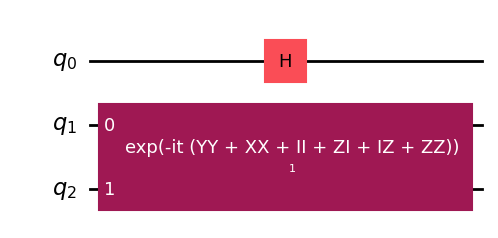

In [35]:
# Approximate hamilonian using QDrift
reps = 10
time = 1
evo_gate_qdrift = PauliEvolutionGate(qubit_op, time, synthesis=QDrift(reps=reps))

qc_qdrift = QuantumCircuit(3)
# need a control qubit for the evolution gate
qc_qdrift.h(0)
qc_qdrift.append(evo_gate, [1, 2])

qc_qdrift.draw('mpl')


In [38]:
# Use Quantum phase estimation to estimate the ground state energy (eigenvalue) of the Hamiltonian

from qiskit_algorithms.optimizers import L_BFGS_B # optimizer suggested for VQE
from qiskit.primitives import Estimator # Estimator to estimate the expectation value of the Hamiltonian

optimizer = L_BFGS_B()
estimator = Estimator()

# setup the ansatz for VQE. This is our "guess" for the ground state of the Hamiltonian. UCSSD is a common choice, recommended by qiskit_nature
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

num_spin_orbitals = 2
num_particles = (1, 1)
qubit_mapping = JordanWignerMapper()
two_qubit_reduction = False
z2symmetry_reduction = None

initial_state = HartreeFock(num_spin_orbitals, num_particles, qubit_mapping)

ansatz = UCCSD(num_spin_orbitals, num_particles, qubit_mapping)

# setup the VQE algorithm
from qiskit_algorithms import VQE

vqe = VQE(estimator=estimator, optimizer=optimizer, ansatz=ansatz)
# ensure that the optimizer starts in the all-zero state which corresponds to
# the Hartree-Fock starting point
vqe.initial_point = [0] * ansatz.num_parameters

In [ ]:
# Baby's first phase estimation + qDRIFT
from qiskit.quantum_info import Pauli, Operator
import random
from functools import reduce
import numpy as np
from qiskit import QuantumCircuit

def generate_random_hamiltonian(num_qubits, num_terms):
    # Generate a random Pauli string
    pauli_matrices = [Pauli('X'), Pauli('Y'), Pauli('Z'), Pauli('I')]
    hamiltonian_terms = []
    for _ in range(num_terms):
        pauli_string = reduce(lambda x, y: x.tensor(y), random.choices(pauli_matrices, k=num_qubits))
        hamiltonian_terms.append((random.uniform(-1, 1), pauli_string))
    return hamiltonian_terms

def qdrift_channel(hamiltonian_terms, time, num_samples):
    for term in hamiltonian_terms:
        assert isinstance(term[1], Pauli)

    l = sum(term[0] for term in hamiltonian_terms)
    tau = time * l / num_samples
    v_lst = []
    hamiltonian_specific_pmf = [abs(coeff) / l for coeff, _ in hamiltonian_terms]
    for i in range(num_samples):
        j = random.choices(range(num_terms), weights=hamiltonian_specific_pmf, k=1)[0]
        # append e^{i*l*hamltonian_terms[j][1]} to v_lst
        
        v = (1j * l * hamiltonian_terms[j][1]).exp_i()

        # perform phase estimation
        qpe_circuit = QuantumCircuit()

: 